# Machine Learning Tests

## Setup

In [21]:
import mne
import re
import os
import numpy as np
import source_localization as srcl
import MEG_analysis as meg
import machine_learning as ml
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression

from scipy.io import loadmat

from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.decoding import (cross_val_multiscore, LinearModel, SlidingEstimator,
                          get_coef, Vectorizer, Scaler)

%matplotlib inline

In [22]:
folder_dict = meg.get_folder_dict()
subj = 'MF-aligned'
meg_dir = '../../../../MEG_raw01/170131_fujita_SD'
should_save_evoked_figs = False
should_train_model = True
source_localization_dir = "/usr/local/freesurfer/subjects"

In [5]:
epochs, evoked = meg.get_processed_meg_data(subj, folder_dict, meg_dir)
src, bem = srcl.get_processed_mri_data(subj, source_localization_dir)
cov = mne.compute_covariance(epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)
fwd = srcl.make_forward_sol(evoked, src, bem, "%s/%s-trans.fif" % (meg_dir, subj))

Reading ../Data/Epochs/MF-aligned-epo.fif ...
    Read a total of 10 projection items:
        grad_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 5)
10 project

In [29]:
def calc_accuracy(y_pred, y_test):
    total = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]:
            total+=1

    return total / len(y_pred)

## RNN model

### Initialize Train, Test Data

In [4]:
inv_op_epoch = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, depth=0.8)
stc_epoch = mne.minimum_norm.apply_inverse_epochs(epochs, inv_op_epoch, 0.11, return_generator=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 204 channels.
    204 out of 204 channels remain after picking
Selected 204 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7955/8196 = 10.006844
    scale = 1.91128e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 5)
Computing rank from covariance with rank=None
    Using tolerance 8.4e-14 (2.2e-16 eps * 204 dim * 1.9  max singular value)
    Estimated rank (grad): 199
    GRAD: rank 199 computed from 204 data channels with 5 projectors
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weig

In [6]:
X = np.einsum('ikj->ijk', np.array([next(stc_epoch).crop(-0.1, 0.5, False).bin(0.005).data for i in range(500)]))
X_test = np.einsum('ikj->ijk', np.array([next(stc_epoch).crop(-0.1, 0.5, False).bin(0.005).data for i in range(100)]))
del stc_epoch
print(X.shape)

g the current components...
Processing epoch : 294 / 600
combining the current components...
Processing epoch : 295 / 600
combining the current components...
Processing epoch : 296 / 600
combining the current components...
Processing epoch : 297 / 600
combining the current components...
Processing epoch : 298 / 600
combining the current components...
Processing epoch : 299 / 600
combining the current components...
Processing epoch : 300 / 600
combining the current components...
Processing epoch : 301 / 600
combining the current components...
Processing epoch : 302 / 600
combining the current components...
Processing epoch : 303 / 600
combining the current components...
Processing epoch : 304 / 600
combining the current components...
Processing epoch : 305 / 600
combining the current components...
Processing epoch : 306 / 600
combining the current components...
Processing epoch : 307 / 600
combining the current components...
Processing epoch : 308 / 600
combining the current components.

In [4]:
y = []
for i in range(6):
    y_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block%s_data.mat" % (i + 1)
    y += ml.classify_target_gabors(y_path)  
y = np.array(y)

y_test_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block6_data.mat"
y_test = np.array(ml.classify_target_gabors(y_test_path))

(600,)
[0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1

### Train model with RNN

In [ ]:
model = ml.RNNModel(n_epochs=20)
model.fit(X, y)

### Evaluate Performance

In [10]:
model.evaluate(X_test, y_test)
y_pred =model.predict(X_test)
y_pred = np.round(y_pred.T[0])
accuracy = calc_accuracy(y_pred, y_test)
print(accuracy)

4/4 [==============================] - 0s 48ms/step - loss: 3.0936 - accuracy: 0.4400
[[8.67474318e-01]
 [7.68474460e-01]
 [1.41701102e-03]
 [1.05051895e-05]
 [1.60766542e-01]
 [1.44395116e-07]
 [2.87047029e-03]
 [9.76958156e-01]
 [3.46988440e-04]
 [6.45359755e-01]
 [9.88131344e-01]
 [9.98375893e-01]
 [1.89206004e-03]
 [9.99396563e-01]
 [1.92737579e-03]
 [8.73655081e-04]
 [1.41799450e-03]
 [2.74057508e-01]
 [9.99995351e-01]
 [7.58019090e-02]
 [9.62904334e-01]
 [9.90729809e-01]
 [4.68027592e-02]
 [9.98585939e-01]
 [9.99988377e-01]
 [9.07273531e-01]
 [8.05427313e-01]
 [5.34722745e-01]
 [1.44485011e-06]
 [2.15798616e-04]
 [9.99891877e-01]
 [9.67189670e-02]
 [3.90861213e-01]
 [9.99250412e-01]
 [9.91312742e-01]
 [2.07343698e-03]
 [9.86536264e-01]
 [9.45280790e-01]
 [9.43899393e-01]
 [3.32803637e-01]
 [7.33391702e-01]
 [3.83538008e-03]
 [9.99652147e-01]
 [4.25731510e-01]
 [9.68708634e-01]
 [6.82381069e-05]
 [7.24726439e-01]
 [4.89320755e-02]
 [9.99999225e-01]
 [1.39030814e-03]
 [9.99225259e-

## Train mne model

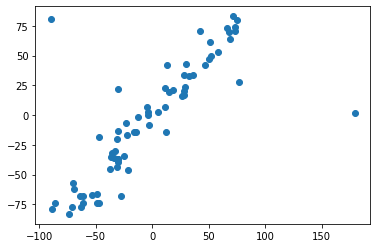

In [3]:
data = loadmat("../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block6_data.mat")
response = data["GabOrSpec"]
target = data["TargetGabor"]

plt.scatter(response, target)

In [6]:
inv_op_epoch = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, depth=0.8)
stc_epoch = mne.minimum_norm.apply_inverse_epochs(epochs, inv_op_epoch, 0.11, return_generator=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 204 channels.
    204 out of 204 channels remain after picking
Selected 204 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7955/8196 = 10.006844
    scale = 1.91128e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 5)
Computing rank from covariance with rank=None
    Using tolerance 8.4e-14 (2.2e-16 eps * 204 dim * 1.9  max singular value)
    Estimated rank (grad): 199
    GRAD: rank 199 computed from 204 data channels with 5 projectors
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weig

In [5]:
X = np.array([next(stc_epoch).crop(-0.2, 0.8).bin(0.01).lh_data for i in range(500)])
X_test = np.array([next(stc_epoch).crop(-0.2, 0.8).bin(0.01).lh_data for i in range(100)])
del stc_epoch
print(X.shape)

g the current components...
Processing epoch : 294 / 600
combining the current components...
Processing epoch : 295 / 600
combining the current components...
Processing epoch : 296 / 600
combining the current components...
Processing epoch : 297 / 600
combining the current components...
Processing epoch : 298 / 600
combining the current components...
Processing epoch : 299 / 600
combining the current components...
Processing epoch : 300 / 600
combining the current components...
Processing epoch : 301 / 600
combining the current components...
Processing epoch : 302 / 600
combining the current components...
Processing epoch : 303 / 600
combining the current components...
Processing epoch : 304 / 600
combining the current components...
Processing epoch : 305 / 600
combining the current components...
Processing epoch : 306 / 600
combining the current components...
Processing epoch : 307 / 600
combining the current components...
Processing epoch : 308 / 600
combining the current components.

In [7]:
y = []
for i in range(5):
    y_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block%s_data.mat" % (i + 1)
    y += ml.classify_target_gabors(y_path)
y = np.array(y)

y_test_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block6_data.mat"
y_test = np.array(ml.classify_target_gabors(y_test_path))

In [8]:
# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=300),  # select features for speed
                    LinearModel(LogisticRegression(C=1, solver='saga')))
time_decod = SlidingEstimator(clf, scoring='roc_auc')

scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

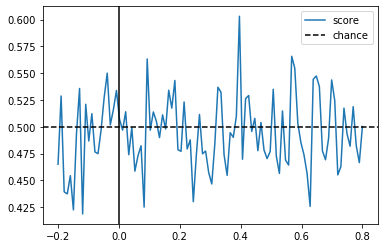

In [9]:
# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(np.linspace(-0.2, 0.8, 100), scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()
plt.show()

## Test with just epochs data

In [23]:
epochs, evoked = meg.get_processed_meg_data(subj, folder_dict, meg_dir)

Reading ../Data/Epochs/MF-aligned-epo.fif ...
    Read a total of 10 projection items:
        grad_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 5)
10 project

In [24]:
def get_y():
    y = []
    for i in range(6):
        y_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block%s_data.mat" % (i + 1)
        y += ml.classify_target_gabors(y_path)
        
    y = np.array(y)
    return y

In [25]:
labels = epochs.events[:, -1]
meg_epochs = epochs.copy().pick_types(meg=True, eeg=False).crop(0, 0.4, False).filter(5, 40)
meg_data = meg_epochs.get_data().reshape(len(labels), -1)
#clf = LogisticRegression(penalty="elasticnet", solver='saga', l1_ratio=0.5, C=0.05, max_iter=25)
clf = LinearRegression()
scaler = StandardScaler()

model = clf

Setting up band-pass filter from 5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (1.651 sec)



In [ ]:
check_evoked = meg_epochs.average()
check_evoked.pick_types('grad').plot_topo(color='r')
plt.show()

In [26]:
y = get_y()
#X = scaler.fit_transform(meg_data)
X = meg_data

X_test, y_test = X[550:], y[550:]
X, y = X[:550], y[:550]

print(X_test.shape)
print(y_test.shape)
print(X.shape)
print(y.shape)

(50, 81600)
(50,)
(550, 81600)
(550,)


In [27]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

0.0
[0.396523   0.37404348 0.34686251 0.62002513 0.29715239 0.60520143
 0.40618229 0.51402821 0.68251537 0.4588205  0.51575834 0.21209132
 0.26995807 0.69188224 0.66545724 0.51359893 0.36612364 0.40896314
 0.57628453 0.34954261 0.25437013 0.29166072 0.50305321 0.46064814
 0.14902162 0.31611829 0.52365207 0.62579264 0.27375574 0.31818396
 0.71406056 0.45267268 0.58904953 0.25324354 0.25387225 0.52273573
 0.53462583 0.70388536 0.44454671 0.40295595 0.08962246 0.6189266
 0.46558037 0.33646124 0.70871765 0.63269273 0.53041803 0.60006077
 0.47124923 0.50451418]
[0.46111111 0.25555556 0.12777778 0.38888889 0.67222222 0.12222222
 0.95       0.4        0.96666667 0.53888889 0.         0.42222222
 0.07222222 0.29444444 0.01666667 0.13333333 0.33333333 0.89444444
 0.06111111 0.25       0.18333333 0.73333333 0.05555556 0.30555556
 0.36111111 0.59444444 0.45       0.89444444 0.26111111 0.3
 0.45555556 0.91111111 0.62222222 0.95       0.51111111 0.08888889
 0.68333333 0.77777778 0.02222222 0.738888

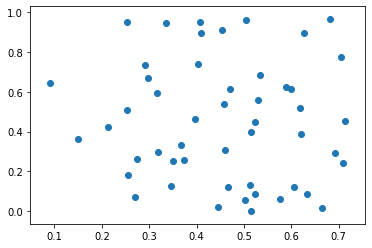

In [32]:
y_pred = model.predict(X_test)
accuracy = calc_accuracy(y_pred, y_test)
print(accuracy)
print(y_pred)
print(y_test)
plt.scatter(y_pred, y_test)

In [33]:
y_pred2 = model.predict(X)
accuracy = calc_accuracy(y_pred2, y)
print(accuracy)

0.0036363636363636364


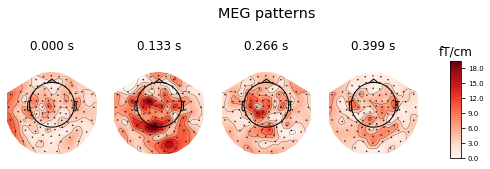

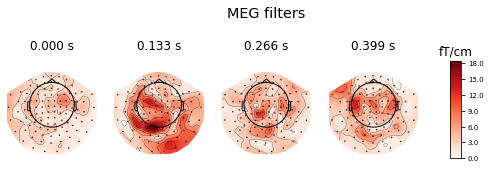

In [43]:
for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
    # We fitted the linear model onto Z-scored data. To make the filters
    # interpretable, we must reverse this normalization step
    coef = scaler.inverse_transform([coef])[0]

    # The data was vectorized to fit a single model across all time points and
    # all channels. We thus reshape it:
    coef = coef.reshape(len(meg_epochs.ch_names), -1)

    # Plot
    meg_evoked = mne.EvokedArray(coef, meg_epochs.info, tmin=0)
    meg_evoked.plot_topomap(title='MEG %s' % name, time_unit='s')

## Compare topomaps between conditions